### Projeto de dados não estruturados 
Objetivo:
<li> Criar um classificador de imagens para gatos e cachorros com <b>redes neurais</b> </li>


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Importando as bibliotecas usadas nesse projeto

In [2]:
# Importando as bibliotecas basics, callback e vision
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
import numpy as np
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, RegexLabeller

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`

from fastai.metrics import error_rate

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageDataLoaders, ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet34, resnet50

### Olhando para o dataset
Queremos tentar identificar 12 espécies de gatos e 25 espécies de cachorros (37 no total). 
Antes de mais nada precisamos de dados. Para tal vamos utilizar uma função do fastai -> untar_data

In [4]:
# Usando o help na função untar_data podemos ver a docstring
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = '~/.fastai') -> 'Path'
    Download `url` using `FastDownload.get`



In [5]:
# baixa o dataset PETS
# com essa função podemos baixar qualquer dataset já pré treinado da biblioteca
path = untar_data(URLs.PETS)

In [6]:
# setando a seed
np.random.seed(2)

In [7]:
# Listando nosso diretório com os dados baixados
path.ls()[:2]

(#2) [Path('/storage/data/oxford-iiit-pet/images'),Path('/storage/data/oxford-iiit-pet/annotations')]

Criando um [DataLoaders](https://docs.fast.ai/data.load.html). Primeiro precisamos do caminho (path) de nossos dados, alguns nomes de arquivos e um regex para extrair nossos labels:

In [8]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

Transformando nossos dados, para trabalhar com nossas imagens com o mesmo tamanho (item_tfms), e normalizando os dados
que será feito na GPU (batch_tfms)


In [9]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]

# Se etiver rodando esse notebook em um PC sem GPU, sugiro que descomente a segunda linha e reinicie o Kernel e tente 
# com um batch size menor.

bs=64
#bs=16

ImageDataLoaders - API de alto nível

In [10]:
# Create from the name attrs of fnames in paths with label_func
# Basicamente um envelope (wrapper) para carregar os dados
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

Quer saber como funciona a API?
* [Veja aqui](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/01_Slides.pdf)

Vamos reconstruir usando a API [DataBlock](https://docs.fast.ai/50_tutorial.datablock.html#building-a-datablock-from-scratch)

Precisaremos definir quais devem ser nossas entradas e saídas (uma imagem e uma categoria para classificação), como obter nossos itens, como dividir nossos dados, como extrair nossos rótulos e nosso aumento como antes

In [11]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [12]:
path_im = path/'images'

In [13]:
dls = pets.dataloaders(path_im, bs=bs)

Podemos dar uma olhada em um lote de nossas imagens usando **show_batch** e passar um número máximo de imagens para mostrar e o tamanho que queremos visualizá-las.


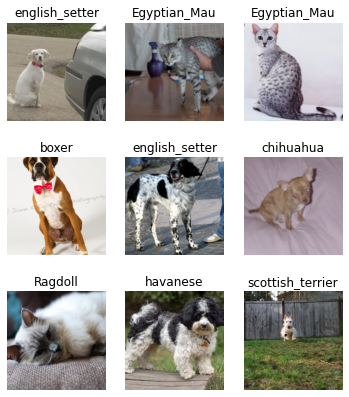

In [14]:
dls.show_batch(max_n=9, figsize=(6,7))

Se quisermos ver quantas classes temos e os nomes delas podemos simplesmente chamar dls.vocab. O primeiro é o número de classes, o segundo são os nomes de nossas classes. Você pode notar que isso parece um pouco estranho, porque esse L é uma nova invenção de Jeremy e Sylvian. Essencialmente, é uma lista Python levada ao extremo.

Antes disso, se quiséssemos pegar o índice para o nome de uma classe (por exemplo, nossa saída de modelo 0 como nossa classe), precisaríamos usar **data.c2i** para pegar o mapeamento da Class2Index. Isso podemos ver aqui **dls.vocab.o2i**.

In [15]:
dls.vocab


['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [16]:
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

### Hora de treinar um modelo!

Usaremos um backbone de rede neural **convolucional** conectado com uma única camada oculta como nosso classificador. Não se preocupe se você não entendeu nada por enquanto. Neste momento, apenas saiba disso: estamos pegando carona em um modelo para nos ajudar a classificar imagens em 37 categorias.

Primeiro, precisamos fazer nossa Rede Neural e nosso Aprendiz([Learner](https://docs.fast.ai/learner.html#learner)) como antes.

Nosso [Learner](https://docs.fast.ai/learner.html#learner) precisa (em um nível básico):

<li>DataLoaders</li>
<li>Alguma arquitetura</li>
<li>Uma métrica de avaliação</li>
<li>Uma função de perda</li>
<li>Um otimizador</li>
<li>Também usaremos mixed_precision (fp16)</li>

In [17]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Algumas suposições feitas aqui:

<li>A função de perda é assumida como classificação, então CrossEntropyFlat</li>
<li>O otimizador é assumido como Adam</li>

Agora, podemos treiná-lo! Vamos treiná-lo por quatro ciclos através de todos os nossos dados

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.849027,0.370774,0.121110,01:06
1,0.643827,0.282768,0.093369,01:06
2,0.362071,0.246258,0.077808,01:06
3,0.266236,0.244165,0.076455,01:06


In [19]:
learn.save('stage_1')

Path('models/stage_1.pth')

### Vamos ver os resultados

Com o modelo treinado, vamos ver onde ele pode ter errado. Quais espécies ele teve dificuldade em diferenciar? Desde que os erros de identificação não sejam muito loucos, nosso modelo está realmente funcionando.

Vamos traçar nossas perdas e fazer uma matriz de confusão para visualizar isso. Abaixo verifica se todas as peças que precisamos estão disponíveis.

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

**plot_top_losses** precisa de **x** número de imagens para usar e um tamanho de figura.

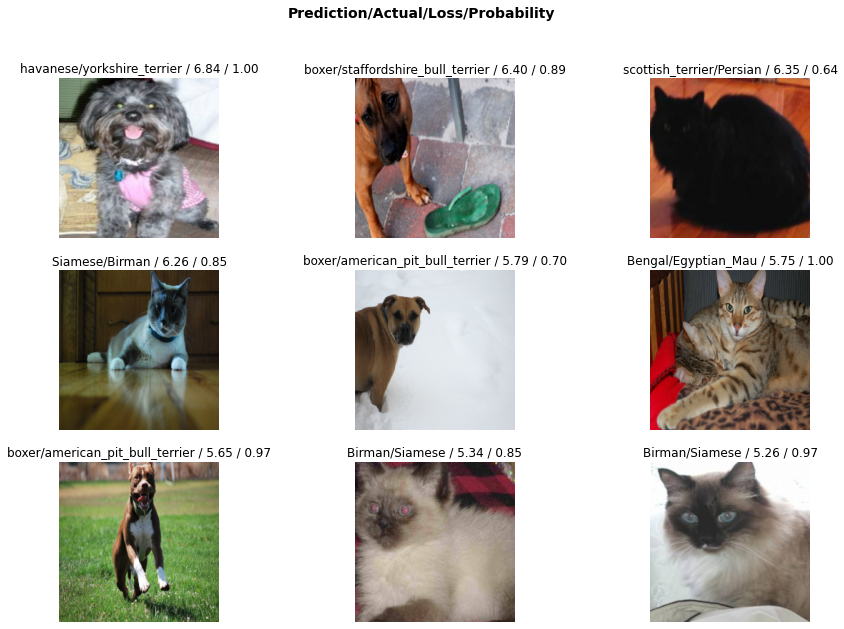

In [21]:
interp.plot_top_losses(9, figsize=(15,10))

plotando a matrix de confusão **plot_confusion_matrix** só precisa de um tamanho de figura. dpi ajusta a qualidade

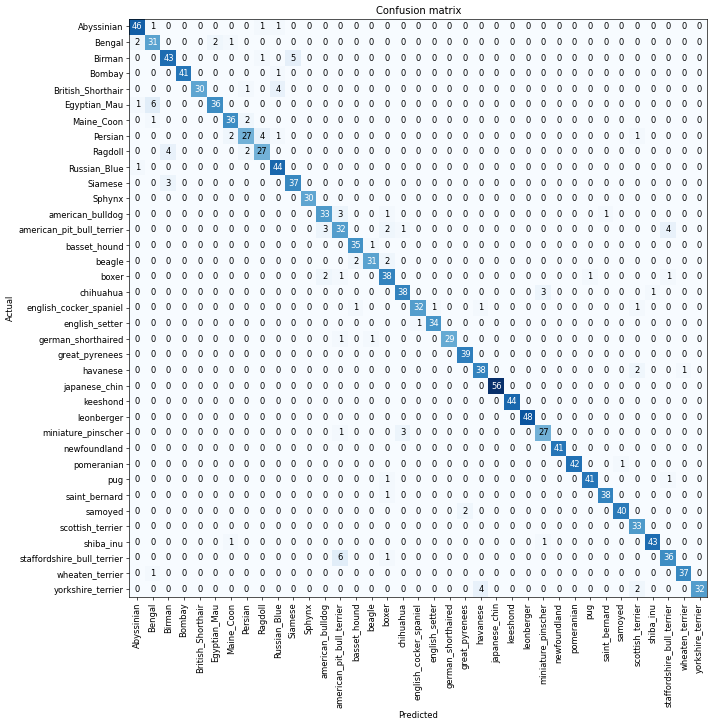

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Também podemos pegar diretamente o nosso mais confuso (uma versão bruta da matriz de confusão) e passar um limite

In [23]:
interp.most_confused(min_val=3)

[('Egyptian_Mau', 'Bengal', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Birman', 'Siamese', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Persian', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('yorkshire_terrier', 'havanese', 4),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('miniature_pinscher', 'chihuahua', 3)]

### Descongelar nossos dados, fazer o ajuste fino (fine tunning) e nossas taxas de aprendizado

Então, nós temos o modelo. Vamos fazer o fine tunning. Primeiro, precisamos carregar nosso modelo de volta.

In [24]:
learn.load('stage_1');

Agora vamos **descongelar** e treinar mais.

O <span style='background: Fuchsia' > congelamento</span> evita que os pesos de uma camada de rede neural sejam modificados durante a passagem inversa do treinamento. Você progressivamente "bloqueia" os pesos para cada camada para reduzir a quantidade de computação na passagem inversa e isso diminui o tempo de treinamento.

Você pode <span style='background: Fuchsia' > descongelar  </span>um modelo se decidir continuar o treinamento - um exemplo disso é o aprendizado de transferência: comece com um modelo pré-treinado, descongele os pesos e continue o treinamento em um conjunto de dados diferente. Quando você escolhe congelar, há um equilíbrio entre congelar cedo o suficiente para ganhar velocidade computacional sem congelar muito cedo com pesos que resultam em previsões imprecisas.


In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.192107,4.119944,0.702977,01:24
1,1.073005,1.612847,0.401218,01:23
2,0.597429,0.537668,0.165765,01:24
3,0.308671,0.485698,0.152233,01:23


Agora, quando descongelamos, descongelamos todas as camadas. Então, para mostrar como é a diferença de uma taxa de aprendizado adequada, vamos carregar esses pesos antigos e tentar usar **lr_find()**

In [27]:
learn.load('stage_1');

SuggestedLRs(valley=1.4454397387453355e-05)

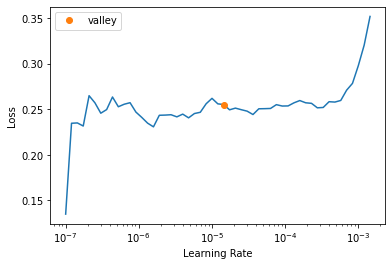

In [28]:
learn.lr_find()

Muito bem, se analisarmos o gráfico, não começamos realmente a aumentar nossas perdas até ~ 10 ^ -2, então o sweet spot está 
entre 1e-6 e 1e-4, vamos fazer isso!

In [30]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))
#learn.fit_one_cycle(4, 1.445) resultado pior

epoch,train_loss,valid_loss,error_rate,time
0,nan,nan,0.966847,01:23
1,nan,nan,0.966847,01:25
2,nan,nan,0.966847,01:23
3,nan,nan,0.966847,01:21


Podemos ver que escolher uma taxa de aprendizado adequada pode ajudar a acelerar as coisas!

In [31]:
learn.save('stage_2')

Path('models/stage_2.pth')

### Agora vamos tentar com um resnet50!
Se você precisar reiniciar seu kernel devido a erros de memória, anexei o código **dls** abaixo

In [32]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

dls = pets.dataloaders(untar_data(URLs.PETS)/"images", bs=32)

Relembrando, seguindo os passos abaixo, devemos ver um aumento na precisão do nosso modelo!

Passos para seguir:

<li>Crie o Learner </li>
<li>Encontrar uma taxa de aprendizado</li>
<li>Usando 5 epochs</li>
<li>Descongelando os dados e ajustando para mais dois</li>

In [34]:
learn = cnn_learner(dls, resnet50, pretrained=True, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0005754399462603033)

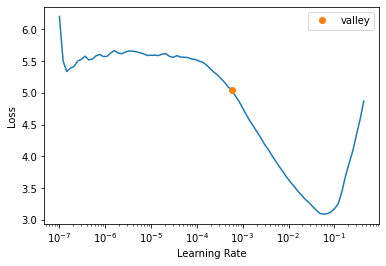

In [35]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(5, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.700977,0.427075,0.121110,01:41
1,0.484038,0.299922,0.090663,01:42
2,0.310813,0.263045,0.079838,01:41
3,0.188889,0.206775,0.054804,01:43
4,0.123657,0.204926,0.055480,01:43


In [37]:
learn.save('resnet50')

Path('models/resnet50.pth')

In [43]:
learn.load('resnet50')
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.840806,1.835604,0.480379,02:13
1,1.007235,0.679506,0.216509,02:13
2,0.432634,0.418372,0.129229,02:13


In [44]:
learn.save('resnet50')

Path('models/resnet50.pth')